# Credit Hungry for EMI Products Model

In [1]:
'''Importing Required Libraries'''
import copy
from collections import OrderedDict
import pandas as pd
import lightgbm as lgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier,SGDRegressor
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
'''Importing the data for modelling'''
ch_data = pd.read_csv(r"D:\Dbeaver Out\CH_EMI_data_2207_202303091535.csv", na_values=['',' ','NH', 'NA', '[]'], low_memory=False)

In [3]:
ch_data.drop(['status','report_source', 'report_id', 'report_date', 'filename_prefix', 'pan_no',
        'passport_no', 'driving_license_no', 'voter_id_no', 'ration_card_no',
        'uid_no', 'national_card_no', 'photo_credit_card_no', 'other_id_no',
        'account_type', 'reported_on', 'frequency', 'income_indicator',
        'ability_to_borrow_cc', 'ability_to_borrow_hl', 'ability_to_borrow_pl',
        'ability_to_borrow_al','created_on', 'modified_on', 'modified_by', 'modified_ts','is_active'],axis=1,inplace=True) 

In [4]:
ch_data.annual_income = ch_data.annual_income.apply(lambda x: (x * -1) if x < 0 else x)
ch_data.drop(ch_data[ch_data['existing_foir'] < 0].index, inplace = True)

In [5]:
ch_data.total_accounts.fillna(0, inplace= True) 
ch_data.negative_status_accounts.fillna(0, inplace= True) 
ch_data.positive_status_accounts.fillna(0, inplace= True) 
ch_data.open_accounts.fillna(0, inplace= True) 
ch_data.closed_accounts.fillna(0, inplace= True) 
ch_data.max_dpd.fillna(0, inplace= True) 
ch_data.credit_utilization.fillna(0, inplace= True) 
ch_data.enquiries_made.fillna(0, inplace= True) 
ch_data.seasoning.fillna(0, inplace= True) 
ch_data.portfolio_mix_secured.fillna(0, inplace= True) 
ch_data.portfolio_mix_unsecured.fillna(0, inplace= True) 
ch_data.related_accounts.fillna(0, inplace= True) 
ch_data.annual_income.fillna(30000, inplace= True) 
ch_data.calculated_emi.fillna(0, inplace= True) 
ch_data.minor_issues.fillna(0, inplace= True) 
ch_data.ontime_payment_percentage.fillna(0, inplace= True) 
ch_data.no_of_delayed_payments.fillna(0, inplace= True) 
ch_data.no_of_delayed_payments_on_active_accounts.fillna(0, inplace= True) 
ch_data.no_of_active_accounts.fillna(0, inplace= True) 
ch_data.existing_foir.fillna(0, inplace= True) 
ch_data.credit_utilization_avg.fillna(0, inplace= True) 

In [6]:
ch_data['p_credit_score'] = np.where(ch_data['p_credit_score']>775,775,ch_data['p_credit_score'])
ch_data['total_accounts'] = np.where(ch_data['total_accounts']>47,47,ch_data['total_accounts'])
ch_data['negative_status_accounts'] = np.where(ch_data['negative_status_accounts']>2,2,ch_data['negative_status_accounts'])
ch_data['positive_status_accounts'] = np.where(ch_data['positive_status_accounts']>23,23,ch_data['positive_status_accounts'])
ch_data['open_accounts'] = np.where(ch_data['open_accounts']>14,14,ch_data['open_accounts'])
ch_data['closed_accounts'] = np.where(ch_data['closed_accounts']>17,17,ch_data['closed_accounts'])
ch_data['max_dpd'] = np.where(ch_data['max_dpd']>120,120,ch_data['max_dpd'])
ch_data['credit_utilization'] = np.where(ch_data['credit_utilization']>100,100,ch_data['credit_utilization'])
ch_data['enquiries_made'] = np.where(ch_data['enquiries_made']>13,13,ch_data['enquiries_made'])
ch_data['seasoning'] = np.where(ch_data['seasoning']>8,8,ch_data['seasoning'])
ch_data['portfolio_mix_secured'] = np.where(ch_data['portfolio_mix_secured']>1,1,ch_data['portfolio_mix_secured'])
ch_data['portfolio_mix_unsecured'] = np.where(ch_data['portfolio_mix_unsecured']>1,1,ch_data['portfolio_mix_unsecured'])
ch_data['related_accounts'] = np.where(ch_data['related_accounts']>5,5,ch_data['related_accounts'])
ch_data['annual_income'] = np.where(ch_data['annual_income']>560000,560000,ch_data['annual_income'])
ch_data['calculated_emi'] = np.where(ch_data['calculated_emi']>75000,75000,ch_data['calculated_emi'])
ch_data['minor_issues'] = np.where(ch_data['minor_issues']>10,10,ch_data['minor_issues'])
ch_data['no_of_delayed_payments'] = np.where(ch_data['no_of_delayed_payments']>45,45,ch_data['no_of_delayed_payments'])
ch_data['no_of_delayed_payments_on_active_accounts'] = np.where(ch_data['no_of_delayed_payments_on_active_accounts']>45,45,ch_data['no_of_delayed_payments_on_active_accounts'])
ch_data['no_of_active_accounts'] = np.where(ch_data['no_of_active_accounts']>10,10,ch_data['no_of_active_accounts'])
ch_data['existing_foir'] = np.where(ch_data['existing_foir']>3500,3500,ch_data['existing_foir'])
ch_data['credit_utilization_avg'] = np.where(ch_data['credit_utilization_avg']>100,100,ch_data['credit_utilization_avg'])
ch_data['is_saleable'] = np.where(ch_data['is_saleable']>4,4,ch_data['is_saleable'])

In [7]:
ch_data.columns

Index(['customer_profile_id', 'user_id', 'p_credit_score', 'p_occupation',
       'p_equifax_income', 'p_customer_type', 'total_accounts',
       'negative_status_accounts', 'positive_status_accounts', 'open_accounts',
       'closed_accounts', 'max_dpd', 'credit_utilization', 'enquiries_made',
       'seasoning', 'portfolio_mix_secured', 'portfolio_mix_unsecured',
       'related_accounts', 'annual_income', 'calculated_emi', 'minor_issues',
       'ontime_payment_percentage', 'no_of_delayed_payments',
       'no_of_delayed_payments_on_active_accounts', 'no_of_active_accounts',
       'existing_foir', 'credit_utilization_avg', 'is_active', 'is_saleable',
       'sub'],
      dtype='object')

In [8]:
ch_data.annual_income.median()

30000.0

In [9]:
ch_data.shape

(6066394, 30)

C:\Users\Pon kebha.DESKTOP-PI8M9QL\AppData\Local\Temp\ipykernel_5316\3830776909.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ch_data.hist(ax = ax)


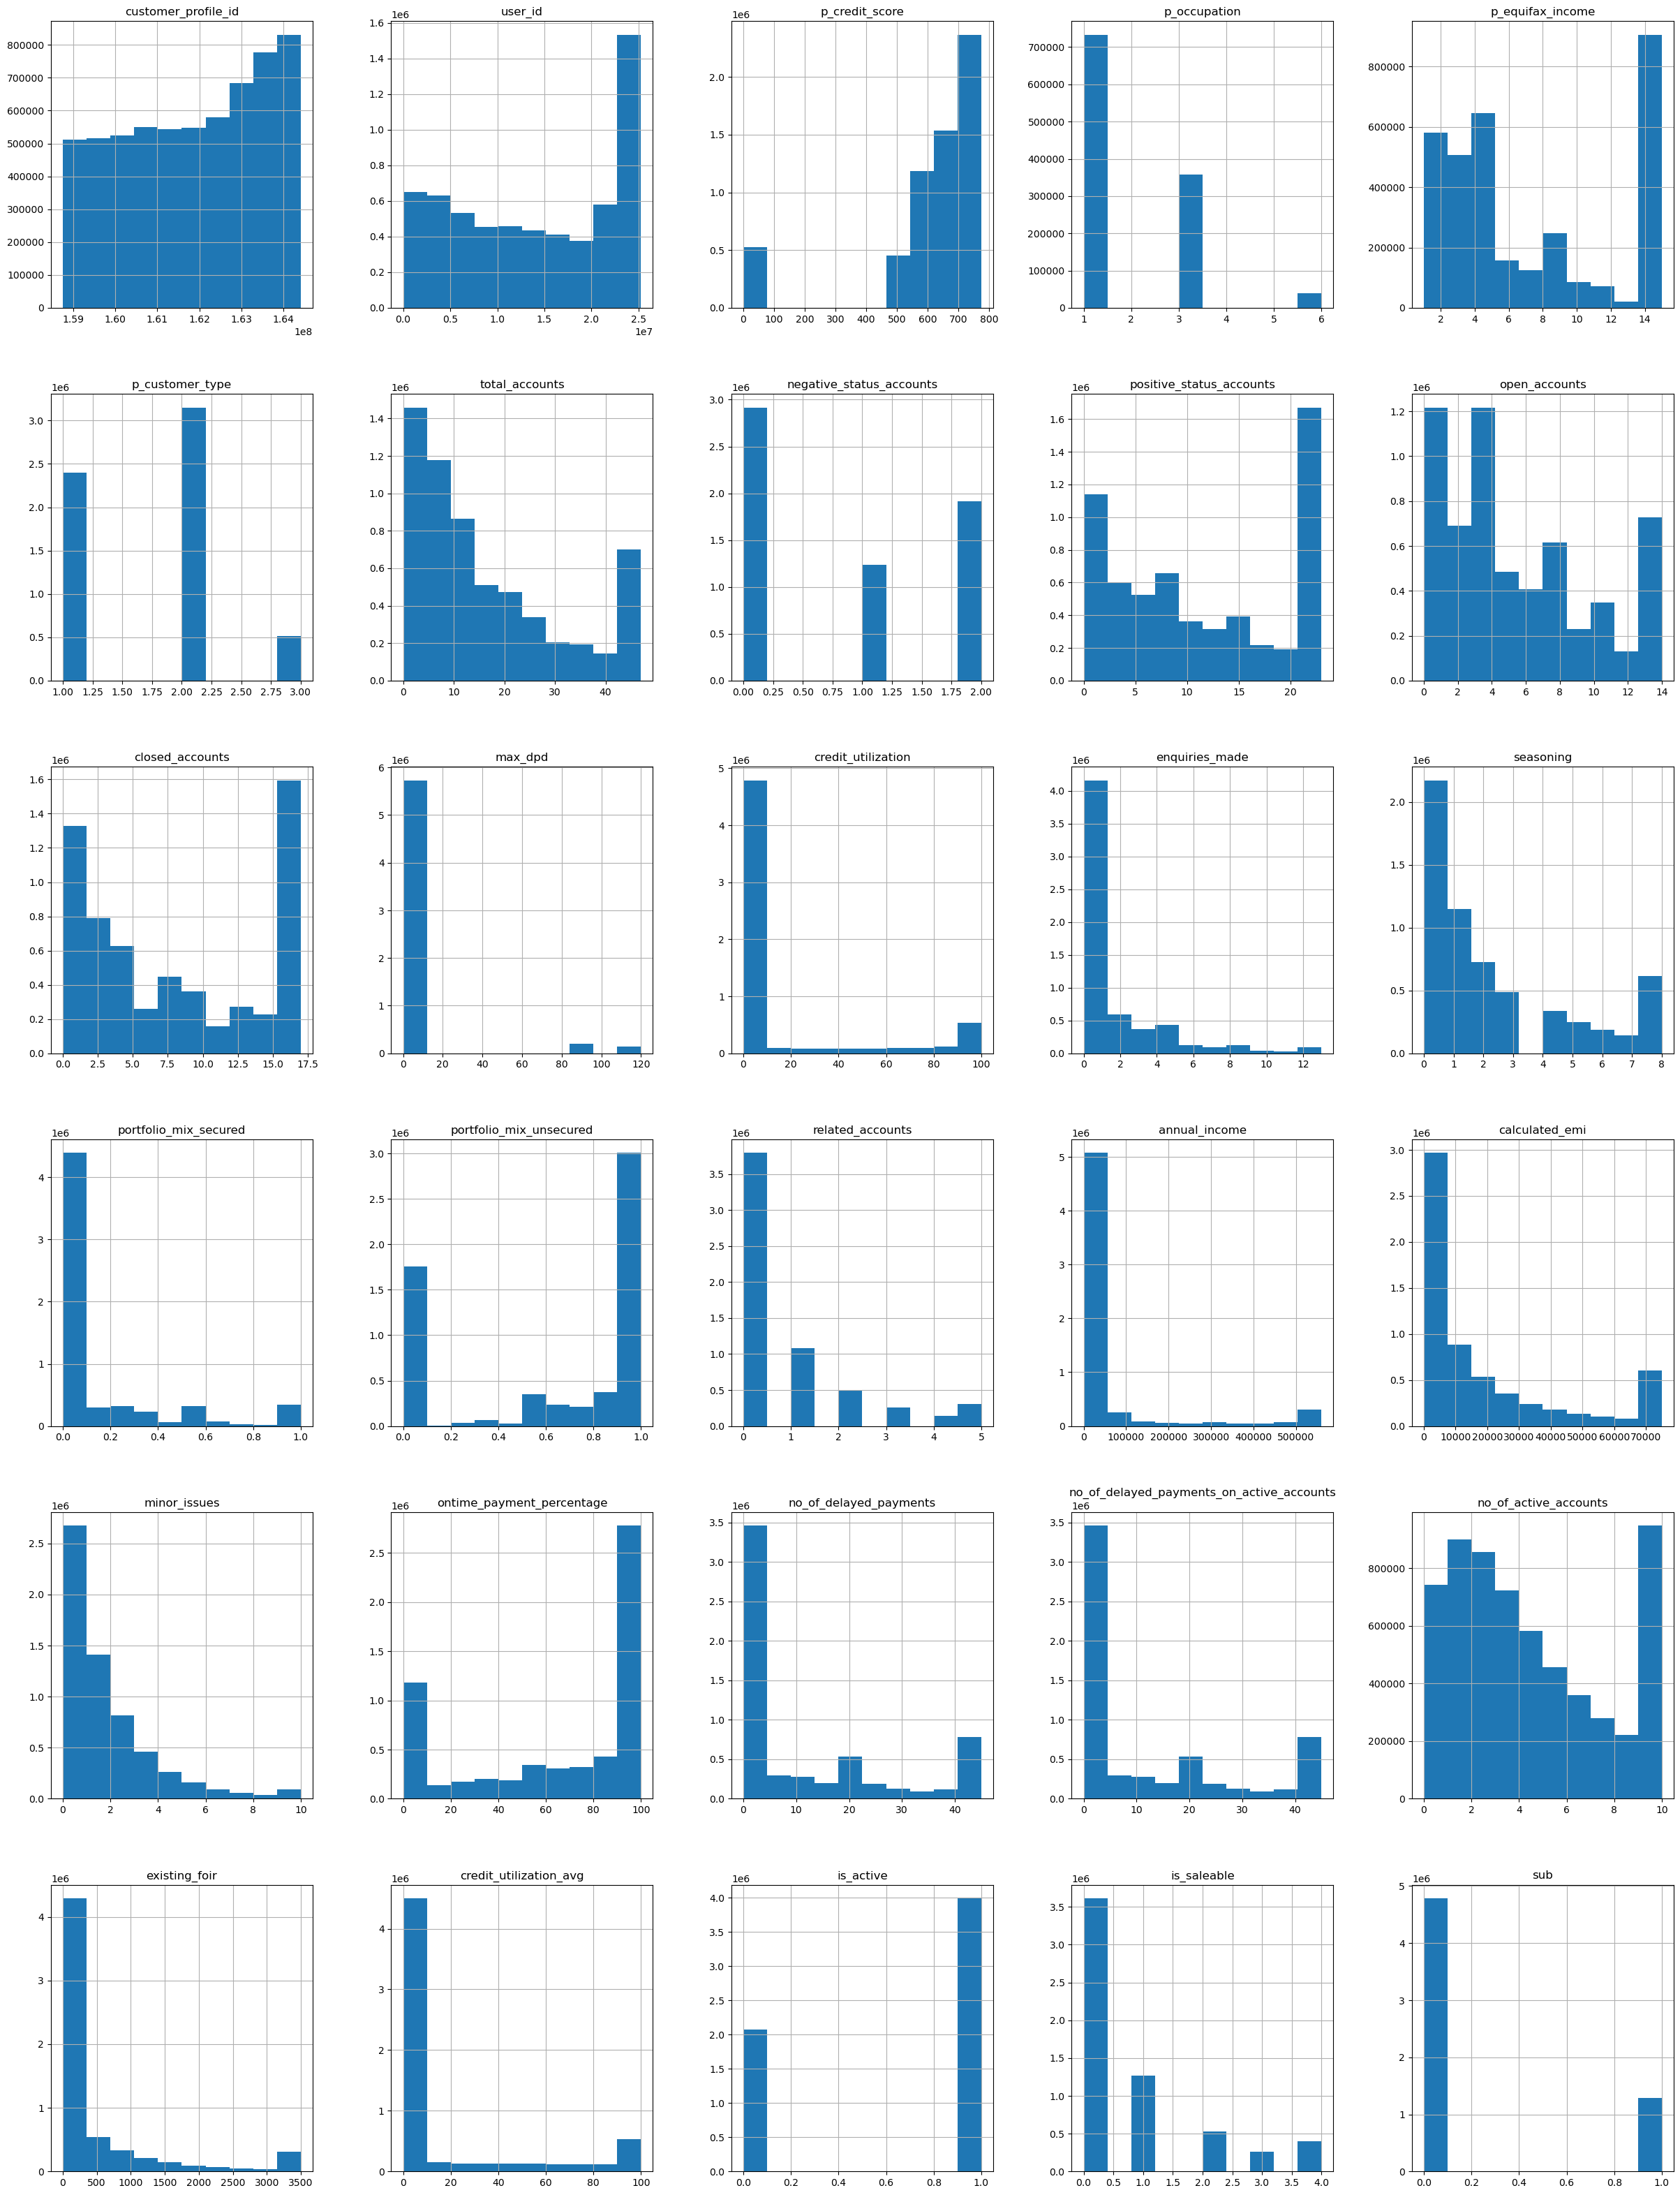

In [10]:
fig = plt.figure(figsize = (30,40))
ax = fig.gca()
ch_data.hist(ax = ax)
pyplot.show()

In [11]:
ch_data.isnull().sum()

customer_profile_id                                0
user_id                                            0
p_credit_score                                     0
p_occupation                                 4935483
p_equifax_income                             2718870
p_customer_type                                    0
total_accounts                                     0
negative_status_accounts                           0
positive_status_accounts                           0
open_accounts                                      0
closed_accounts                                    0
max_dpd                                            0
credit_utilization                                 0
enquiries_made                                     0
seasoning                                          0
portfolio_mix_secured                              0
portfolio_mix_unsecured                            0
related_accounts                                   0
annual_income                                 

In [12]:
''' get_occupation '''
def get_occupation(occupation):
    try:
        if occupation == 9:
            return 'Student'
        elif occupation in [1,2]:
            return 'Salaried'
        elif occupation in [3,4,5,6,7,8]:
            return 'SelfEmployed'
        elif occupation in [10,11]:
            return 'Other'
        else:
            return 'Other'
    except:
        return 'Other'
ch_data['p_occupation'] = ch_data['p_occupation'].apply(lambda x: get_occupation(x))
ch_data['p_occupation'].value_counts()

Other           4935483
Salaried         733051
SelfEmployed     397860
Name: p_occupation, dtype: int64

In [13]:
''' get_salary '''
def get_salary(salary):
    try:
        if salary == 1:
            return '<10k'
        elif salary == 2:
            return '10-15k'
        elif salary == 3:
            return '15-20k'
        elif salary == 4:
            return '20-25k'
        elif salary == 5:
            return '25-30k'
        elif salary == 6:
            return '30-35k'
        elif salary == 7:
            return '35-40k'
        elif salary == 8:
            return '40-45k'
        elif salary == 9:
            return '40-45k'
        elif salary == 10:
            return '40-45k'
        elif salary == 11:
            return '40-45k'
        elif salary == 12:
            return '40-45k'
        elif salary == 13:
            return '40-45k'
        elif salary ==14:
            return '40-45k'
        elif salary == 15:
            return '40-45k'
        else:
            return 'Other'
    except:
        return 'Other'
ch_data['p_equifax_income'] = ch_data['p_equifax_income'].apply(lambda x: get_salary(x))
ch_data['p_equifax_income'].value_counts()

Other     2718870
40-45k    1333019
15-20k     507677
20-25k     382092
10-15k     376295
25-30k     264452
<10k       203424
30-35k     156153
35-40k     124412
Name: p_equifax_income, dtype: int64

In [14]:
''' get_p_customer_type '''
def get_p_customer_type(type):
    try:
        if type == 1:
            return 'Green'
        elif type == 2:
            return 'Red'
        else:
            return 'Amber'
    except:
        return 'Amber'
ch_data['p_customer_type'] = ch_data['p_customer_type'].apply(lambda x: get_p_customer_type(x))
ch_data['p_customer_type'].value_counts()

Red      3150197
Green    2399118
Amber     517079
Name: p_customer_type, dtype: int64

In [15]:
joblib.dump(ch_data, 'ch_clean_data.pkl')

['ch_clean_data.pkl']

In [16]:
ch_data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,customer_profile_id,user_id,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_active,is_saleable,sub
customer_profile_id,1.0,0.056,0.018,0.13,-0.039,0.11,0.11,0.096,-0.006,0.05,0.19,0.2,-0.042,0.12,0.024,-0.029,0.048,-0.056,0.1,-0.0062,-0.0062,0.17,0.07,0.026,0.5,-0.03,0.32
user_id,0.056,1.0,-0.21,-0.32,-0.36,-0.34,-0.3,-0.36,-0.075,-0.21,0.0015,-0.028,-0.069,-0.077,-0.26,-0.21,-0.28,-0.27,-0.033,-0.3,-0.3,-0.26,-0.17,-0.24,0.29,-0.36,0.11
p_credit_score,0.018,-0.21,1.0,0.26,0.028,0.35,0.3,0.29,-0.015,0.11,0.17,0.28,0.13,0.37,0.12,0.094,0.19,0.15,0.46,-0.0092,-0.0092,0.3,0.12,0.11,-0.06,0.0034,0.099
total_accounts,0.13,-0.32,0.26,1.0,0.23,0.92,0.81,0.91,0.073,0.3,0.41,0.6,0.03,0.33,0.41,0.12,0.45,0.6,0.3,0.22,0.22,0.74,0.43,0.29,0.0068,0.21,0.32
negative_status_accounts,-0.039,-0.36,0.028,0.23,1.0,0.16,0.2,0.27,0.26,0.068,-0.062,-0.21,0.087,-0.11,0.17,0.059,0.12,0.23,-0.32,0.75,0.75,0.15,0.098,0.15,-0.25,0.75,-0.2
positive_status_accounts,0.11,-0.34,0.35,0.92,0.16,1.0,0.78,0.95,0.044,0.3,0.38,0.6,0.063,0.4,0.4,0.16,0.46,0.53,0.41,0.15,0.15,0.73,0.4,0.28,-0.017,0.13,0.28
open_accounts,0.11,-0.3,0.3,0.81,0.2,0.78,1.0,0.66,0.088,0.4,0.44,0.74,0.026,0.44,0.4,0.19,0.56,0.66,0.4,0.24,0.24,0.94,0.45,0.38,0.0073,0.21,0.31
closed_accounts,0.096,-0.36,0.29,0.91,0.27,0.95,0.66,1.0,0.066,0.24,0.32,0.45,0.059,0.28,0.38,0.12,0.39,0.48,0.26,0.22,0.22,0.6,0.37,0.24,-0.048,0.23,0.24
max_dpd,-0.006,-0.075,-0.015,0.073,0.26,0.044,0.088,0.066,1.0,-0.0022,-0.011,-0.057,0.032,-0.039,0.11,0.011,0.085,0.097,-0.1,0.24,0.24,0.069,0.056,0.017,-0.048,0.19,-0.055
credit_utilization,0.05,-0.21,0.11,0.3,0.068,0.3,0.4,0.24,-0.0022,1.0,0.17,0.29,-0.041,0.22,0.16,0.22,0.32,0.22,0.18,0.11,0.11,0.41,0.21,0.8,-0.016,0.11,0.08


In [17]:
exclude=[]

In [18]:
numerical_columns=list(ch_data.select_dtypes(include='number').columns)
for feature in numerical_columns:
    if feature in exclude:
        pass
    else:
        numerical_columns.remove(feature)
print(numerical_columns)

['user_id', 'total_accounts', 'positive_status_accounts', 'closed_accounts', 'credit_utilization', 'seasoning', 'portfolio_mix_unsecured', 'annual_income', 'minor_issues', 'no_of_delayed_payments', 'no_of_active_accounts', 'credit_utilization_avg', 'is_active', 'sub']


In [19]:
skewed=[]
def find_skew(data,numerical_columns):
    skew_list={}
    for feature in numerical_columns:
        try:
            try:
                skew_value=(3*(data[feature].mean()-data[feature].median()))/data[feature].std()
                if ((round(skew_value,2)<-3) or (round(skew_value,2)>3)):
                    skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                    skewed.append(feature)
                else:
                    skew_list[feature]=round(skew_value,2)
            except ZeroDivisionError:
                skew_list[feature]='Skewwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww'
                skewed.append(feature)
        except:
            pass
    return skew_list
skew_list=find_skew(ch_data,numerical_columns)
skew_list

{'user_id': -0.11,
 'total_accounts': 0.9,
 'positive_status_accounts': 0.57,
 'closed_accounts': 0.5,
 'credit_utilization': 1.42,
 'seasoning': 1.43,
 'portfolio_mix_unsecured': -1.77,
 'annual_income': 1.02,
 'minor_issues': 0.6,
 'no_of_delayed_payments': 1.84,
 'no_of_active_accounts': 0.97,
 'credit_utilization_avg': 1.57,
 'is_active': -2.16,
 'sub': 1.55}

In [20]:
for i in numerical_columns:
    if i in exclude:
        pass
    else:
        try:
            ch_data[i] =stats.boxcox(array)
        except:
            pass
find_skew(ch_data,numerical_columns)

{'user_id': -0.11,
 'total_accounts': 0.9,
 'positive_status_accounts': 0.57,
 'closed_accounts': 0.5,
 'credit_utilization': 1.42,
 'seasoning': 1.43,
 'portfolio_mix_unsecured': -1.77,
 'annual_income': 1.02,
 'minor_issues': 0.6,
 'no_of_delayed_payments': 1.84,
 'no_of_active_accounts': 0.97,
 'credit_utilization_avg': 1.57,
 'is_active': -2.16,
 'sub': 1.55}

In [21]:
joblib.dump(ch_data, 'ch_transformed_data.pkl')

['ch_transformed_data.pkl']

In [22]:
user_ids=pd.concat([ch_data['user_id'].reset_index(drop = True)], axis = 1)
ch_data.drop(['user_id'],axis=1,inplace=True)

In [23]:
customer_profile_id=pd.concat([ch_data['customer_profile_id'].reset_index(drop = True)], axis = 1)
ch_data.drop(['customer_profile_id'],axis=1,inplace=True)

In [24]:
categorical_features=list(ch_data.select_dtypes(exclude='number').columns)
categorical_features

['p_occupation', 'p_equifax_income', 'p_customer_type']

In [25]:
exemption_features=['sub']

In [26]:
numeric_features=list(ch_data.select_dtypes(include='number').columns)
numeric_features
flag_features=[]
for feature in exemption_features:
    numeric_features.remove(feature)
for feature in exclude:
    if feature in numeric_features:
        flag_features.append(feature)
        numeric_features.remove(feature)

In [27]:
id_columns=['user_id','customer_profile_id']
exemption_features=['sub']

In [28]:
dummies = pd.get_dummies(data = ch_data[categorical_features], drop_first=False)
dummies.columns

Index(['p_occupation_Other', 'p_occupation_Salaried',
       'p_occupation_SelfEmployed', 'p_equifax_income_10-15k',
       'p_equifax_income_15-20k', 'p_equifax_income_20-25k',
       'p_equifax_income_25-30k', 'p_equifax_income_30-35k',
       'p_equifax_income_35-40k', 'p_equifax_income_40-45k',
       'p_equifax_income_<10k', 'p_equifax_income_Other',
       'p_customer_type_Amber', 'p_customer_type_Green',
       'p_customer_type_Red'],
      dtype='object')

In [29]:
'''Scaling numeric features'''
standard_scalar = StandardScaler(with_mean=True,with_std=True)
standard_scalar.fit(ch_data[numeric_features])
numeric_data_scaled = standard_scalar.transform(ch_data[numeric_features])
numeric_data_scaled = pd.DataFrame(numeric_data_scaled,columns=numeric_features)
numeric_data_scaled.head()

,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable
0,-3.00,-1.12,-0.95,-1.37,-1.25,-1.24,-0.24,-0.47,-0.60,-0.86,-0.50,-1.46,-0.60,-0.34,-0.79,-0.72,-1.67,-0.74,-0.74,-1.24,-0.52,-0.52,-0.66
1,-3.00,-0.98,-0.95,-1.13,-0.79,-1.24,-0.24,-0.47,-0.60,-0.48,-0.50,0.84,-0.60,-0.34,-0.62,-0.20,0.89,-0.74,-0.74,-0.94,-0.52,-0.52,-0.66
2,0.61,-0.57,0.19,-0.54,-0.33,-0.63,-0.24,-0.47,-0.60,0.28,-0.50,0.84,-0.60,-0.19,-0.69,-0.20,0.89,-0.74,-0.74,-0.32,-0.46,-0.52,0.19
3,-0.14,-1.05,0.19,-1.37,-1.02,-1.24,-0.24,-0.47,-0.22,-0.86,-0.50,-1.46,-0.60,-0.34,-0.79,-0.20,-1.67,-0.74,-0.74,-1.24,-0.52,2.56,0.19
4,-3.00,-1.05,-0.95,-1.25,-1.02,-1.24,-0.24,-0.47,-0.60,-0.48,-0.50,0.84,-0.60,-0.34,-0.75,-0.72,0.89,-0.74,-0.74,-0.94,-0.52,-0.52,-0.66


In [30]:
'''Concatenating all features'''
processed_dataset = pd.concat([user_ids['user_id'].reset_index(drop = True), 
                               customer_profile_id['customer_profile_id'].reset_index(drop = True), 
                               numeric_data_scaled.reset_index(drop = True),
                               ch_data[flag_features].reset_index(drop = True),
                               dummies.reset_index(drop = True),
                              ch_data[exemption_features].reset_index(drop = True)
                              ], axis=1)
processed_dataset.shape

(6066394, 42)

In [31]:
joblib.dump(processed_dataset, 'ch_processed_data.pkl')

['ch_processed_data.pkl']

In [32]:
processed_dataset.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,user_id,customer_profile_id,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable,is_active,p_occupation_Other,p_occupation_Salaried,p_occupation_SelfEmployed,p_equifax_income_10-15k,p_equifax_income_15-20k,p_equifax_income_20-25k,p_equifax_income_25-30k,p_equifax_income_30-35k,p_equifax_income_35-40k,p_equifax_income_40-45k,p_equifax_income_<10k,p_equifax_income_Other,p_customer_type_Amber,p_customer_type_Green,p_customer_type_Red,sub
user_id,1.0,0.056,-0.21,-0.32,-0.36,-0.34,-0.3,-0.36,-0.075,-0.21,0.0015,-0.028,-0.069,-0.077,-0.26,-0.21,-0.28,-0.27,-0.033,-0.3,-0.3,-0.26,-0.17,-0.24,-0.36,0.29,0.11,-0.098,-0.044,0.029,0.00062,-0.029,-0.042,-0.042,-0.046,-0.26,-0.052,0.28,0.31,0.17,-0.34,0.11
customer_profile_id,0.056,1.0,0.018,0.13,-0.039,0.11,0.11,0.096,-0.006,0.05,0.19,0.2,-0.042,0.12,0.024,-0.029,0.048,-0.056,0.1,-0.0062,-0.0062,0.17,0.07,0.026,-0.03,0.5,0.0061,0.0033,-0.014,0.016,0.031,0.036,0.029,0.023,0.02,-0.016,-0.0086,-0.051,-0.0035,0.044,-0.041,0.32
p_credit_score,-0.21,0.018,1.0,0.26,0.028,0.35,0.3,0.29,-0.015,0.11,0.17,0.28,0.13,0.37,0.12,0.094,0.19,0.15,0.46,-0.0092,-0.0092,0.3,0.12,0.11,0.0034,-0.06,-0.1,0.092,0.04,0.067,0.073,0.059,0.047,0.035,0.031,0.12,0.043,-0.26,-0.92,0.46,0.062,0.099
total_accounts,-0.32,0.13,0.26,1.0,0.23,0.92,0.81,0.91,0.073,0.3,0.41,0.6,0.03,0.33,0.41,0.12,0.45,0.6,0.3,0.22,0.22,0.74,0.43,0.29,0.21,0.0068,-0.07,0.069,0.019,0.057,0.12,0.15,0.13,0.11,0.1,0.22,0.032,-0.48,-0.32,-0.0012,0.18,0.32
negative_status_accounts,-0.36,-0.039,0.028,0.23,1.0,0.16,0.2,0.27,0.26,0.068,-0.062,-0.21,0.087,-0.11,0.17,0.059,0.12,0.23,-0.32,0.75,0.75,0.15,0.098,0.15,0.75,-0.25,-0.047,0.029,0.035,0.025,0.044,0.054,0.049,0.04,0.034,0.13,0.045,-0.23,-0.29,-0.77,0.92,-0.2
positive_status_accounts,-0.34,0.11,0.35,0.92,0.16,1.0,0.78,0.95,0.044,0.3,0.38,0.6,0.063,0.4,0.4,0.16,0.46,0.53,0.41,0.15,0.15,0.73,0.4,0.28,0.13,-0.017,-0.069,0.067,0.019,0.06,0.12,0.14,0.13,0.11,0.096,0.25,0.043,-0.51,-0.39,0.082,0.14,0.28
open_accounts,-0.3,0.11,0.3,0.81,0.2,0.78,1.0,0.66,0.088,0.4,0.44,0.74,0.026,0.44,0.4,0.19,0.56,0.66,0.4,0.24,0.24,0.94,0.45,0.38,0.21,0.0073,-0.069,0.081,0.0017,0.029,0.089,0.12,0.11,0.096,0.088,0.25,0.034,-0.44,-0.34,0.045,0.15,0.31
closed_accounts,-0.36,0.096,0.29,0.91,0.27,0.95,0.66,1.0,0.066,0.24,0.32,0.45,0.059,0.28,0.38,0.12,0.39,0.48,0.26,0.22,0.22,0.6,0.37,0.24,0.23,-0.048,-0.063,0.057,0.025,0.069,0.13,0.15,0.13,0.11,0.095,0.23,0.044,-0.5,-0.36,-0.027,0.23,0.24
max_dpd,-0.075,-0.006,-0.015,0.073,0.26,0.044,0.088,0.066,1.0,-0.0022,-0.011,-0.057,0.032,-0.039,0.11,0.011,0.085,0.097,-0.1,0.24,0.24,0.069,0.056,0.017,0.19,-0.048,-0.0042,-0.013,0.024,-0.001,-0.00082,0.0039,0.0052,0.0061,0.0054,0.048,0.011,-0.05,-0.073,-0.19,0.23,-0.055
credit_utilization,-0.21,0.05,0.11,0.3,0.068,0.3,0.4,0.24,-0.0022,1.0,0.17,0.29,-0.041,0.22,0.16,0.22,0.32,0.22,0.18,0.11,0.11,0.41,0.21,0.8,0.11,-0.016,-0.066,0.081,-0.0028,-0.035,-0.013,0.015,0.028,0.037,0.043,0.22,0.022,-0.21,-0.14,0.027,0.052,0.08


In [33]:
ch_data.describe(percentiles=[0.01,0.05,0.10,0.25,0.5,0.75,0.9,0.95,0.99],datetime_is_numeric=True).transpose()

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
p_credit_score,6066394.00,602.57,200.59,0.00,0.00,0.00,500.00,575.00,675.00,725.00,750.00,775.00,775.00,775.00
total_accounts,6066394.00,16.42,14.70,0.00,0.00,0.00,1.00,5.00,12.00,24.00,47.00,47.00,47.00,47.00
negative_status_accounts,6066394.00,0.83,0.88,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,2.00,2.00,2.00
positive_status_accounts,6066394.00,11.61,8.49,0.00,0.00,0.00,1.00,4.00,10.00,22.00,23.00,23.00,23.00,23.00
open_accounts,6066394.00,5.45,4.34,0.00,0.00,0.00,1.00,2.00,4.00,8.00,14.00,14.00,14.00,14.00
closed_accounts,6066394.00,8.07,6.50,0.00,0.00,0.00,0.00,2.00,7.00,16.00,17.00,17.00,17.00,17.00
max_dpd,6066394.00,5.65,23.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,90.00,120.00,120.00
credit_utilization,6066394.00,15.14,32.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,84.52,100.00,100.00,100.00
enquiries_made,6066394.00,1.56,2.60,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,7.00,13.00,13.00
seasoning,6066394.00,2.26,2.64,0.00,0.00,0.00,0.00,0.00,1.00,4.00,8.00,8.00,8.00,8.00


In [34]:
'''Replace Infinite'''
processed_dataset = processed_dataset.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
processed_dataset.shape

(6066394, 42)

In [80]:
data=processed_dataset[[
 'max_dpd',
 'p_equifax_income_10-15k',
 'p_equifax_income_25-30k',
 'p_occupation_SelfEmployed',
 'p_equifax_income_20-25k',
 'p_equifax_income_15-20k',
 'p_equifax_income_Other',
 'p_occupation_Salaried',
 'p_occupation_Other',
 'p_customer_type_Red',
 'p_customer_type_Green',
 'negative_status_accounts',
 'is_saleable',
 'portfolio_mix_secured',
 'related_accounts',
 'minor_issues',
 'credit_utilization',
 'no_of_delayed_payments',
 'no_of_delayed_payments_on_active_accounts',
 'credit_utilization_avg',
 'open_accounts',
 'portfolio_mix_unsecured',
 'closed_accounts',
 'annual_income',
 'p_credit_score',
 'positive_status_accounts',
 'existing_foir',
 'no_of_active_accounts',
 'ontime_payment_percentage',
 'total_accounts',
 'enquiries_made',
 'seasoning',
 'calculated_emi',
#  'is_active',
 'sub']]

In [81]:
'''  Splitting test and train data '''
# data=processed_dataset.drop(['customer_profile_id'],axis=1)

X = data.loc[:,data.columns != 'sub']
y = data['sub']
train_X_u,test_X_u,train_y,test_y = train_test_split(X,y,random_state=31,test_size=0.1)
train_X = train_X_u.loc[:,train_X_u.columns != 'user_id']
test_X = test_X_u.loc[:,test_X_u.columns != 'user_id']

In [71]:
train_X.head()

,p_credit_score,total_accounts,negative_status_accounts,positive_status_accounts,open_accounts,closed_accounts,max_dpd,credit_utilization,enquiries_made,seasoning,portfolio_mix_secured,portfolio_mix_unsecured,related_accounts,annual_income,calculated_emi,minor_issues,ontime_payment_percentage,no_of_delayed_payments,no_of_delayed_payments_on_active_accounts,no_of_active_accounts,existing_foir,credit_utilization_avg,is_saleable,is_active,p_occupation_Other,p_occupation_Salaried,p_occupation_SelfEmployed,p_equifax_income_10-15k,p_equifax_income_15-20k,p_equifax_income_20-25k,p_equifax_income_25-30k,p_equifax_income_30-35k,p_equifax_income_35-40k,p_equifax_income_40-45k,p_equifax_income_<10k,p_equifax_income_Other,p_customer_type_Amber,p_customer_type_Green,p_customer_type_Red
1790329,0.36,-0.30,1.33,-0.43,-0.33,-0.01,-0.24,-0.47,-0.60,-0.86,-0.50,0.84,-0.60,-0.22,-0.14,-0.72,-1.15,2.09,2.09,-0.02,-0.08,-0.52,2.73,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
474029,0.61,-0.16,-0.95,0.28,0.13,-0.01,-0.24,0.22,-0.60,-0.86,-0.50,0.84,-0.60,2.75,-0.59,1.36,0.89,-0.74,-0.74,-0.63,-0.51,-0.06,-0.66,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3465972,0.49,-0.91,-0.95,-1.01,-1.02,-0.93,-0.24,-0.47,-0.60,-0.86,-0.50,0.84,-0.60,-0.34,-0.73,-0.72,0.89,-0.74,-0.74,-0.94,-0.52,-0.52,-0.66,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
218069,0.24,-0.64,0.19,-0.66,-0.33,-0.78,-0.24,-0.47,0.94,-0.48,-0.50,0.84,3.08,-0.46,-0.09,-0.20,-0.18,0.96,0.96,-0.32,0.98,-0.52,-0.66,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
113726,-0.26,-0.30,1.33,-0.31,0.36,-0.32,4.84,2.65,-0.60,-0.86,-0.50,0.84,1.61,0.65,2.40,-0.72,-0.57,2.09,2.09,0.91,0.84,2.56,0.19,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [79]:
#RandomForest
''' Tuning Grid '''
gridParams = {
#                 'n_estimators': [100],
#                 'max_features':['sqrt'],
#                 'bootstrap': [True],
                'random_state' : [12],
#                 'warm_start':[False],
                'criterion':['gini', 'entropy'],
#                 'max_depth':[47],
                'min_samples_split':[0.01,0.001,0.0005],
                'min_samples_leaf':[0.01,0.001,0.0005]
             }

'''Model Object'''
model2 = RandomForestClassifier()

''' Grid Formation '''
grid = RandomizedSearchCV(estimator = model2 , param_distributions= gridParams, verbose = 2, cv = 3, n_iter=1000)
grid.fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 18 is smaller than n_iter=1000. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.01, random_state=12; total time= 7.0min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.01, random_state=12; total time= 7.2min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.01, random_state=12; total time= 7.2min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.001, random_state=12; total time= 7.2min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.001, random_state=12; total time= 7.2min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.001, random_state=12; total time= 7.1min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.0005, random_state=12; total time= 7.1min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.0005, random_state=12; total time= 7.4min
[CV] END criterion=gini, min_samples_leaf=0.01, min_samples_split=0.

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=1000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [0.01, 0.001,
                                                             0.0005],
                                        'min_samples_split': [0.01, 0.001,
                                                              0.0005],
                                        'random_state': [12]},
                   verbose=2)

In [82]:
#RandomForest

'''Model Object'''
model = RandomForestClassifier(criterion='entropy', min_samples_leaf=0.0005,
                       min_samples_split=0.001, random_state=12)
model.fit(train_X, train_y)

RandomForestClassifier(criterion='entropy', min_samples_leaf=0.0005,
                       min_samples_split=0.001, random_state=12)

In [ ]:
dict(sorted(dict(zip(grid.feature_names_in_, model.feature_importances_)).items(), key=lambda item: item[1]))

In [ ]:
dict(sorted(dict(zip(model.feature_names_in_, model.feature_importances_)).items(), key=lambda item: item[1]))

In [42]:
joblib.dump(grid,"CH_EMI_RF_v1.pkl")

['CH_EMI_RF_v1.pkl']

In [83]:
joblib.dump(model,"CH_EMI_RF_v1.2.pkl")

['CH_EMI_RF_v1.2.pkl']

In [46]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', min_samples_leaf=0.0005,
                       min_samples_split=0.001, random_state=12)

In [51]:
test_fit2 = grid.predict(test_X)
y_pred=pd.DataFrame(test_fit2)

In [84]:
test_fit1 = model.predict(test_X)
y_pred1=pd.DataFrame(test_fit1)

In [85]:
test_fit3 = model.predict(train_X)
y_pred3=pd.DataFrame(test_fit3)

In [54]:
accuracy_score(test_y, y_pred)

0.8808519055782672

In [86]:
accuracy_score(test_y, y_pred1)

0.8621604246340498

In [87]:
accuracy_score(train_y, y_pred3)

0.8624051559832183

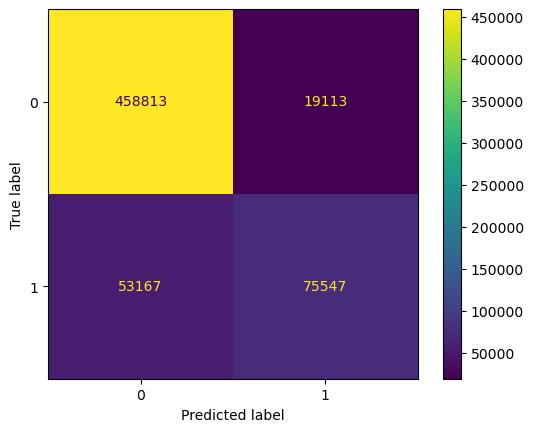

In [57]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred))
cm.plot()
plt.show()

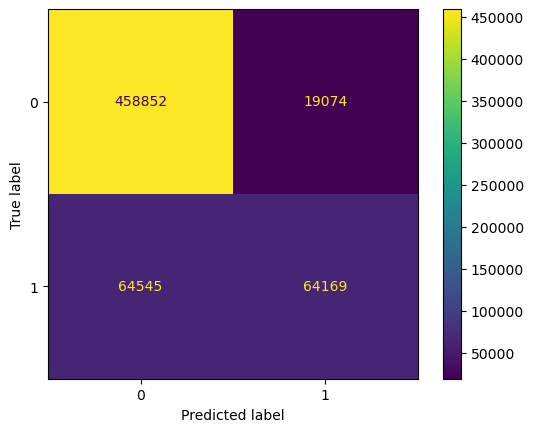

In [88]:
cm=ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred1))
cm.plot()
plt.show()

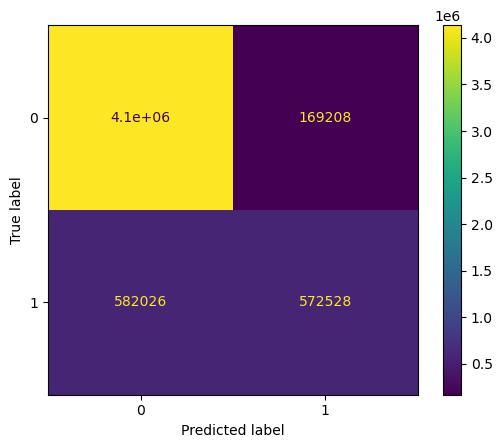

In [89]:
cm=ConfusionMatrixDisplay(confusion_matrix(train_y, y_pred3))
cm.plot()
plt.show()

In [60]:
false_positive_rate, true_positive_rate, threshold1 = roc_curve(test_y, y_pred)
'roc='+str(roc_auc_score(test_y, y_pred))

'roc=0.7734726915645949'

In [90]:
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_y, y_pred1)
'roc='+str(roc_auc_score(test_y, y_pred1))

'roc=0.7293147266032199'

In [91]:
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(train_y, y_pred3)
'roc='+str(roc_auc_score(train_y, y_pred3))

'roc=0.7282917775482367'

In [63]:
mae = mean_absolute_error(test_y, y_pred)
mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.11914809442173283
MSE: 0.11914809442173283
RMSE: 0.345178351612225
R-Squared: 0.28720812205589275


In [92]:
mae = mean_absolute_error(test_y, y_pred1)
mse = mean_squared_error(test_y, y_pred1)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(test_y, y_pred1)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.13783957536595015
MSE: 0.13783957536595015
RMSE: 0.3712675253317345
R-Squared: 0.175388156588153


In [93]:
mae = mean_absolute_error(train_y, y_pred3)
mse = mean_squared_error(train_y, y_pred3)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = r2_score(train_y, y_pred3)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 0.1375948440167817
MSE: 0.1375948440167817
RMSE: 0.37093778995511056
R-Squared: 0.17483513316223598


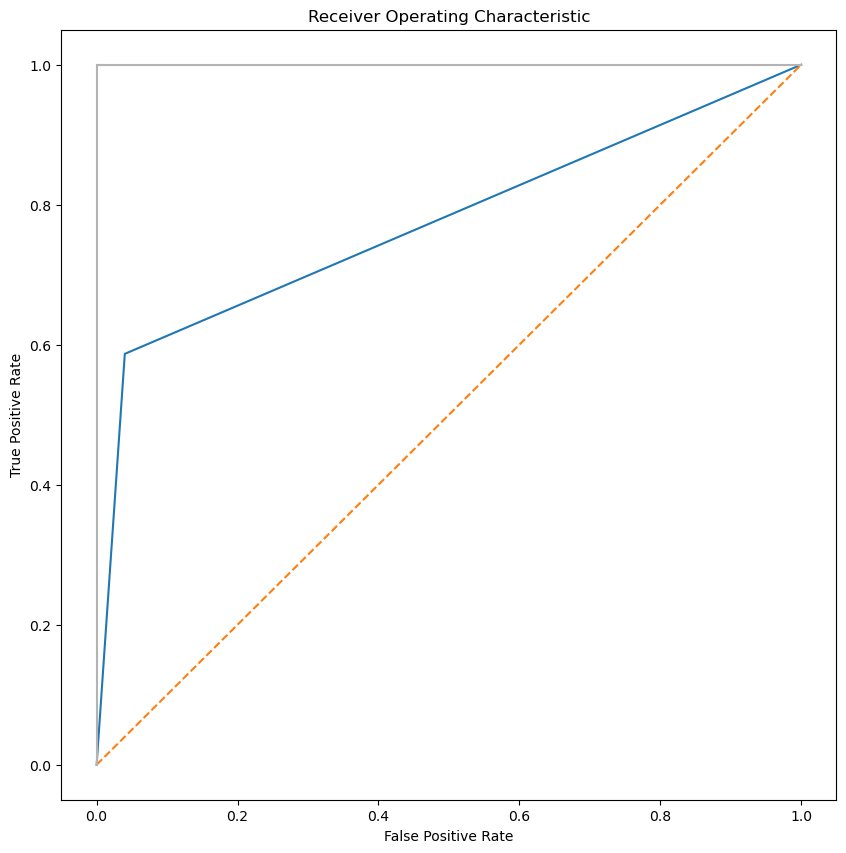

In [66]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

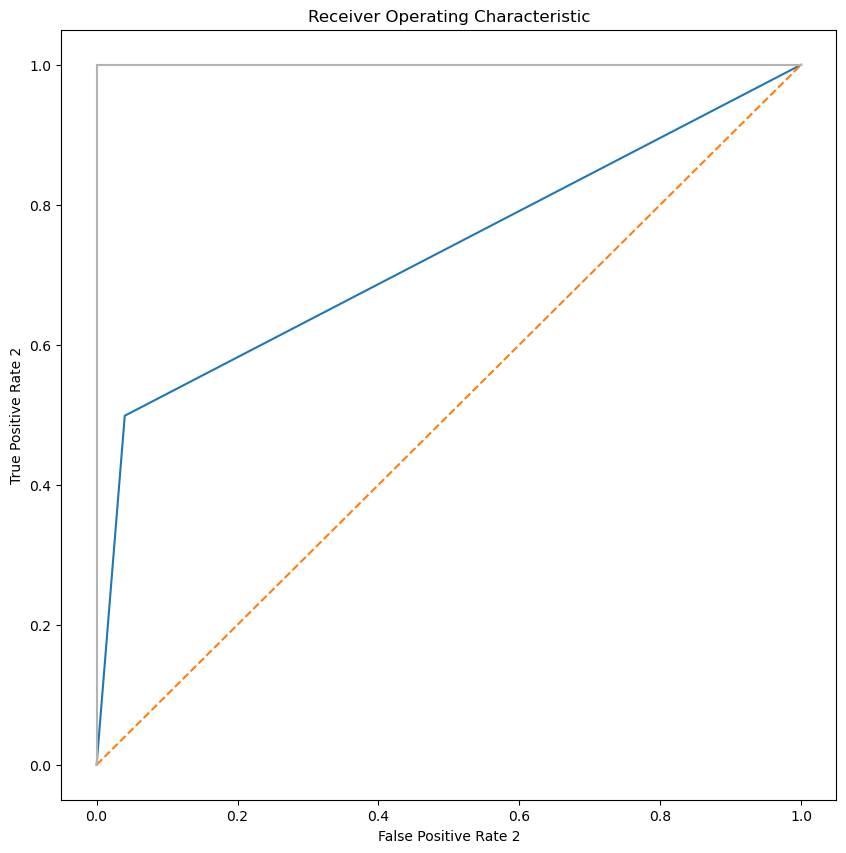

In [94]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate 2')
plt.xlabel('False Positive Rate 2')
plt.show()

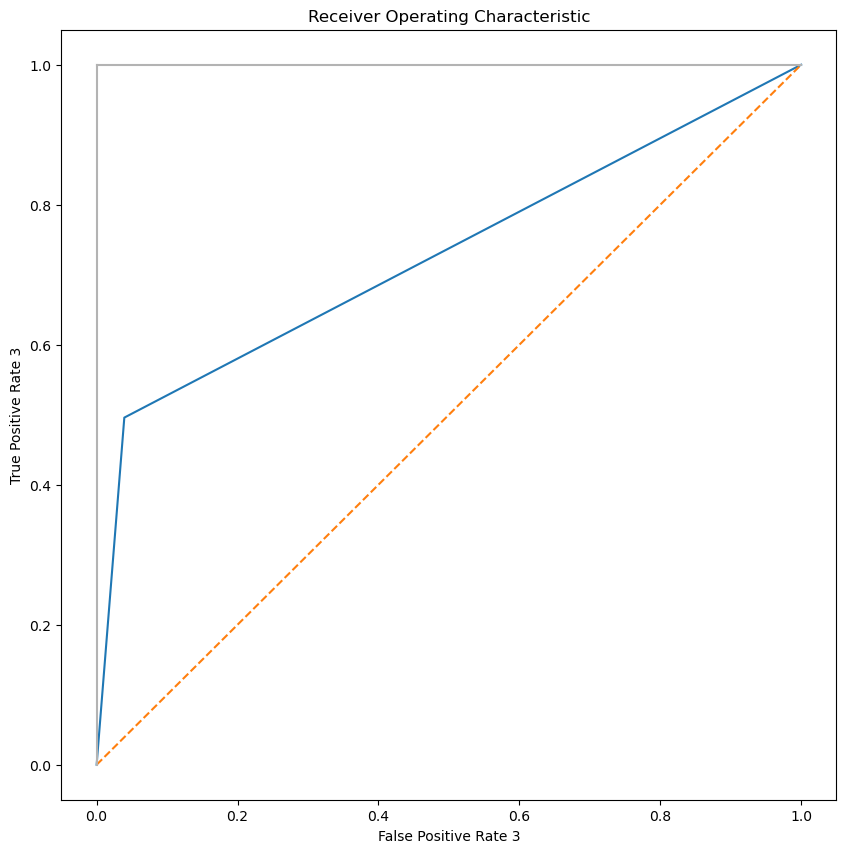

In [95]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate 3')
plt.xlabel('False Positive Rate 3')
plt.show()